## Renko chart Strategy


### Renko chart is a chart itself that came from Japan where renki means bricks
###  It only form a brick in the chart when a stock moves by a dollar or custome value amount
### Buy the stock when three consecutive green bricks are formed and sell when two consecutive bricks are formed

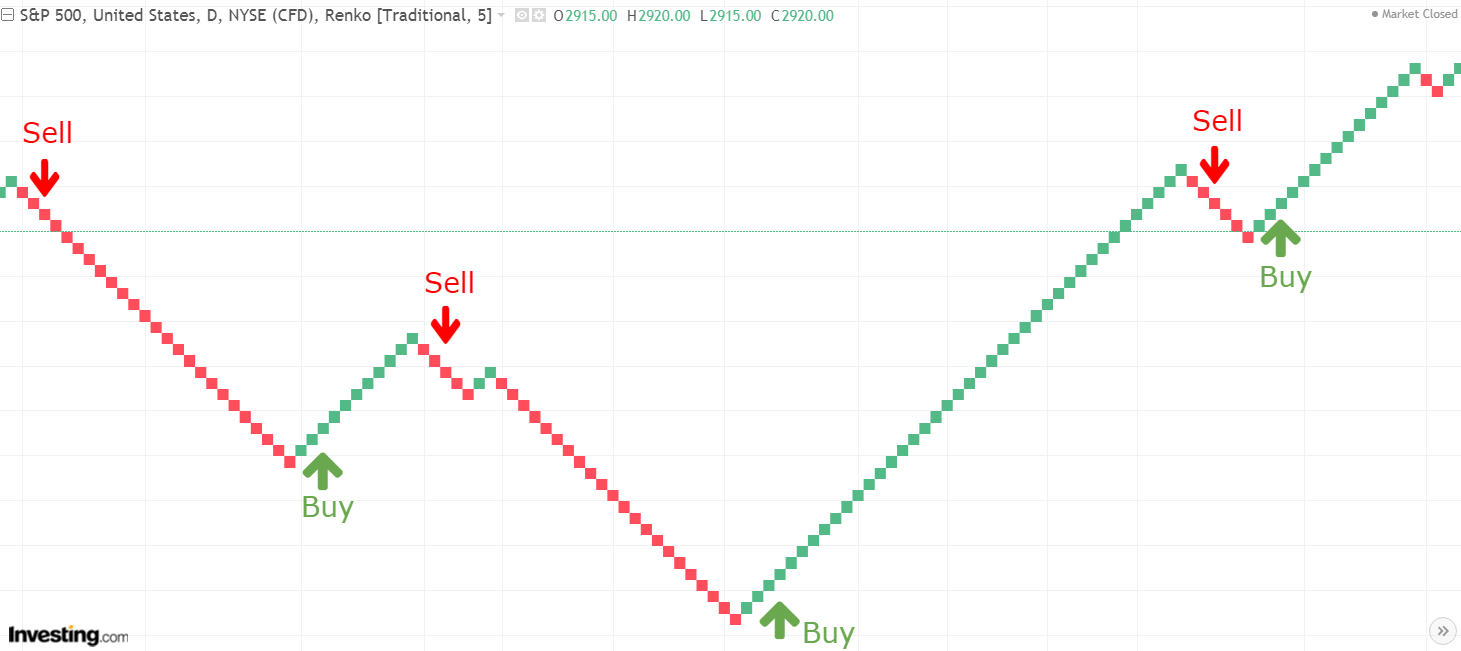

In [1]:
import numpy as np
import pandas as pd
import copy
import time
import datetime as dt
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from stocktrends import Renko

In [2]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

In [3]:
def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

In [4]:
def renko_DF(DF,brick_size):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,4,5]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    #df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    df2.brick_size = brick_size
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df

In [5]:
def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Adj Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['Volume'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

In [6]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)  #252 trading days #252*6.5 trading hours #252*6.5*12 (5mins)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

In [7]:
def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)  #252 as it is day candle stick #52 if it is week candle stick
    return vol

In [8]:
def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

In [9]:
def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [10]:
spy=pd.read_csv("SPY_intraday.csv")
spy.index=pd.to_datetime(spy["Datetime"])
spy.drop("Datetime",axis=1,inplace=True)

In [11]:
spy

,Open,High,Low,Close,Volume,hours
Datetime,,,,,,
2005-01-03 09:30:00,87.0610,87.1326,87.0109,87.1111,1251700,intraday
2005-01-03 09:35:00,87.1111,87.2042,87.0968,87.1827,934900,intraday
2005-01-03 09:40:00,87.1541,87.1684,87.0968,87.1326,865500,intraday
2005-01-03 09:45:00,87.1326,87.1684,87.0753,87.0968,584700,intraday
2005-01-03 09:50:00,87.1326,87.1326,87.0180,87.0180,621600,intraday
...,...,...,...,...,...,...
2022-11-25 15:30:00,402.3600,402.3600,402.3600,402.3600,100,intraday
2022-11-25 15:35:00,402.4800,402.4800,402.4800,402.4800,900,intraday
2022-11-25 15:40:00,402.4800,402.4800,402.3900,402.3900,611,intraday


In [12]:
spy

,Open,High,Low,Close,Volume,hours
Datetime,,,,,,
2005-01-03 09:30:00,87.0610,87.1326,87.0109,87.1111,1251700,intraday
2005-01-03 09:35:00,87.1111,87.2042,87.0968,87.1827,934900,intraday
2005-01-03 09:40:00,87.1541,87.1684,87.0968,87.1326,865500,intraday
2005-01-03 09:45:00,87.1326,87.1684,87.0753,87.0968,584700,intraday
2005-01-03 09:50:00,87.1326,87.1326,87.0180,87.0180,621600,intraday
...,...,...,...,...,...,...
2022-11-25 15:30:00,402.3600,402.3600,402.3600,402.3600,100,intraday
2022-11-25 15:35:00,402.4800,402.4800,402.4800,402.4800,900,intraday
2022-11-25 15:40:00,402.4800,402.4800,402.3900,402.3900,611,intraday


<AxesSubplot:xlabel='Datetime'>

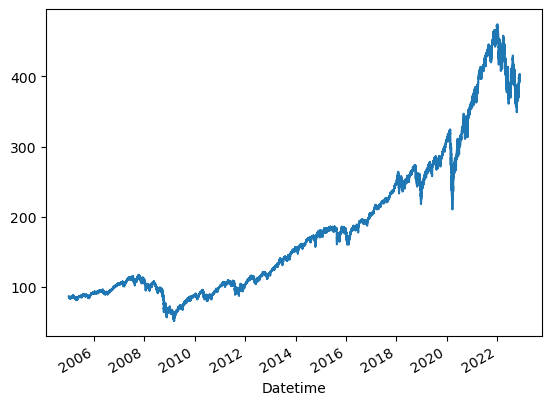

In [13]:
spy["Close"].plot()

In [14]:
renko=renko_DF(spy,brick_size=0.50)
renko

/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_13178/3407483437.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_13178/3407483437.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]


,date,open,high,low,close,uptrend,bar_num
0,2005-01-03 09:30:00,86.5,87.0,86.5,87.0,True,1
1,2005-01-03 15:30:00,86.5,86.5,86.0,86.0,False,-1
2,2005-01-04 14:05:00,86.0,86.0,85.5,85.5,False,-2
3,2005-01-04 14:45:00,85.5,85.5,85.0,85.0,False,-3
4,2005-01-12 09:50:00,85.0,85.0,84.5,84.5,False,-4
...,...,...,...,...,...,...,...
24327,2022-11-23 12:55:00,400.5,400.5,400.0,400.0,False,-3
24328,2022-11-23 13:40:00,400.5,401.0,400.5,401.0,True,1
24331,2022-11-23 14:00:00,402.0,402.5,402.0,402.5,True,4
24332,2022-11-23 14:35:00,402.0,402.0,401.5,401.5,False,-1


In [15]:
renko.columns = ["Date","open","high","low","close","uptrend","bar_num"]
spy["Date"] = spy.index
spy = spy.merge(renko.loc[:,["Date","bar_num"]],how="outer",on="Date")
spy["bar_num"].fillna(method='ffill',inplace=True)

In [16]:
spy.index=spy.Date
spy

,Open,High,Low,Close,Volume,hours,Date,bar_num
Date,,,,,,,,
2005-01-03 09:30:00,87.0610,87.1326,87.0109,87.1111,1251700,intraday,2005-01-03 09:30:00,1.0
2005-01-03 09:35:00,87.1111,87.2042,87.0968,87.1827,934900,intraday,2005-01-03 09:35:00,1.0
2005-01-03 09:40:00,87.1541,87.1684,87.0968,87.1326,865500,intraday,2005-01-03 09:40:00,1.0
2005-01-03 09:45:00,87.1326,87.1684,87.0753,87.0968,584700,intraday,2005-01-03 09:45:00,1.0
2005-01-03 09:50:00,87.1326,87.1326,87.0180,87.0180,621600,intraday,2005-01-03 09:50:00,1.0
...,...,...,...,...,...,...,...,...
2022-11-25 15:30:00,402.3600,402.3600,402.3600,402.3600,100,intraday,2022-11-25 15:30:00,1.0
2022-11-25 15:35:00,402.4800,402.4800,402.4800,402.4800,900,intraday,2022-11-25 15:35:00,1.0
2022-11-25 15:40:00,402.4800,402.4800,402.3900,402.3900,611,intraday,2022-11-25 15:40:00,1.0


In [17]:
spy["atr"]=ATR(spy,120)["ATR"]

In [18]:
spy['atr'][0]

nan

In [19]:
def gain_plot_combination_return(buy_value,sell_value):
    signal_list=[]
    signal=""
    return_list=[]
    stoploss_list=[]
    capital_list=[]
    capital=500
    for i in range(len(spy)):
        if spy.index[i].hour==15 and spy.index[i].minute==55:
            if signal=="Buy Call":
                signal_list.append("Sell")
                signal=""
                return_list.append(spy["Close"][i]-cost)
                stoploss_list.append(0)
            elif signal=="Buy Put":
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-spy["Close"][i])
                stoploss_list.append(0)
            elif signal=="":
                signal_list.append("")
                return_list.append(0)
                stoploss_list.append(0)
        #update       
#         elif spy.index[i].hour>=9 and spy.index[i].minute<=35:
#             signal_list.append("")
#             return_list.append(0)
#             stoploss_list.append(0)
            
        elif signal=="":
            if spy["bar_num"][i]>=buy_value:
                signal="Buy Call"
                signal_list.append(signal)
                cost=spy["Close"][i]
                stoploss=cost-spy["atr"][i]
                return_list.append(0)
                stoploss_list.append(stoploss)

            elif spy["bar_num"][i]<=sell_value:
                signal="Buy Put"
                signal_list.append(signal)
                cost=spy["Close"][i]
                stoploss=cost+spy["atr"][i]
                return_list.append(0)
                stoploss_list.append(stoploss)
            else:
                signal_list.append("")
                return_list.append(0)
                stoploss_list.append(0)
        elif signal=="Buy Call":
            #sell signal
            if spy["bar_num"][i]<=-2:
                signal_list.append("Sell")
                signal=""
                return_list.append(spy["Close"][i]-cost)
                stoploss_list.append(0)
            elif spy["Close"][i]<stoploss:
                signal_list.append("Sell")
                signal=""
                return_list.append(spy["Close"][i]-cost)
                stoploss_list.append(stoploss)

            else:
                signal_list.append("")
                return_list.append(0)
                stoploss_list.append(stoploss)

        elif signal=="Buy Put":
            #sell signal
            if spy["bar_num"][i]>=2:
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-spy["Close"][i])
                stoploss_list.append(0)
            elif spy["Close"][i]>stoploss:
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-spy["Close"][i])
                stoploss_list.append(stoploss)
            else:
                signal_list.append("")
                return_list.append(0)
                stoploss_list.append(stoploss)
        capital=capital+return_list[-1]*50
        capital_list.append(capital)
    spy["capital"]=capital_list
    #return_list=return_list[:-1]
    spy["signal"]=signal_list
    spy["return"]=return_list
    spy["stop_loss"]=stoploss_list
    spy["return_dollar"]=spy["return"]*50
    spy['cum_return']=spy['return'].cumsum()
    spy["cum_return_dollar"]=spy["return_dollar"].cumsum()
    spy["ret"]=spy["capital"].pct_change().fillna(0)
    #spy['cum_return']=spy['return'].cumsum()
    return spy

In [20]:
def gain_plot_no_stoploss(buy_value,sell_value):
    signal_list=[]
    signal=""
    return_list=[]
    
    for i in range(len(spy)):
        if spy.index[i].hour==15 and spy.index[i].minute==57:
            if signal=="Buy Call":
                signal_list.append("Sell")
                signal=""
                return_list.append(spy["Close"][i]-cost)
            elif signal=="Buy Put":
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-spy["Close"][i])
            elif signal=="":
                signal_list.append("")
                return_list.append(0)
        elif signal=="":
            if spy["bar_num"][i]>=buy_value:
                signal="Buy Call"
                signal_list.append(signal)
                cost=spy["Close"][i]
                return_list.append(0)
            elif spy["bar_num"][i]<=sell_value:
                signal="Buy Put"
                signal_list.append(signal)
                cost=spy["Close"][i]
                return_list.append(0)
            else:
                signal_list.append("")
                return_list.append(0)
        elif signal=="Buy Call":
            #sell signal
            if spy["bar_num"][i]<=-2:
                signal_list.append("Sell")
                signal=""
                return_list.append(spy["Close"][i]-cost)
            else:
                signal_list.append("")
                return_list.append(0)

        elif signal=="Buy Put":
            #sell signal
            if spy["bar_num"][i]>=2:
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-spy["Close"][i])
            else:
                signal_list.append("")
                return_list.append(0)
    
    spy["signal"]=signal_list
    spy["return"]=return_list
    spy['cum_return']=spy['return'].cumsum()
    spy["return_dollar"]=spy["return"]*50
    spy["cum_return_dollar"]=spy["return_dollar"].cumsum()
    
    
    return spy

In [21]:
gain_plot_combination_return(buy_value=3,sell_value=-3)

,Open,High,Low,Close,Volume,hours,Date,bar_num,atr,capital,signal,return,stop_loss,return_dollar,cum_return,cum_return_dollar,ret
Date,,,,,,,,,,,,,,,,,
2005-01-03 09:30:00,87.0610,87.1326,87.0109,87.1111,1251700,intraday,2005-01-03 09:30:00,1.0,NaN,500.000,,0.0,0.0,0.0,0.0000,0.000,0.0
2005-01-03 09:35:00,87.1111,87.2042,87.0968,87.1827,934900,intraday,2005-01-03 09:35:00,1.0,NaN,500.000,,0.0,0.0,0.0,0.0000,0.000,0.0
2005-01-03 09:40:00,87.1541,87.1684,87.0968,87.1326,865500,intraday,2005-01-03 09:40:00,1.0,NaN,500.000,,0.0,0.0,0.0,0.0000,0.000,0.0
2005-01-03 09:45:00,87.1326,87.1684,87.0753,87.0968,584700,intraday,2005-01-03 09:45:00,1.0,NaN,500.000,,0.0,0.0,0.0,0.0000,0.000,0.0
2005-01-03 09:50:00,87.1326,87.1326,87.0180,87.0180,621600,intraday,2005-01-03 09:50:00,1.0,NaN,500.000,,0.0,0.0,0.0,0.0000,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25 15:30:00,402.3600,402.3600,402.3600,402.3600,100,intraday,2022-11-25 15:30:00,1.0,0.349082,17647.225,,0.0,0.0,0.0,342.9445,17147.225,0.0
2022-11-25 15:35:00,402.4800,402.4800,402.4800,402.4800,900,intraday,2022-11-25 15:35:00,1.0,0.344666,17647.225,,0.0,0.0,0.0,342.9445,17147.225,0.0
2022-11-25 15:40:00,402.4800,402.4800,402.3900,402.3900,611,intraday,2022-11-25 15:40:00,1.0,0.343332,17647.225,,0.0,0.0,0.0,342.9445,17147.225,0.0


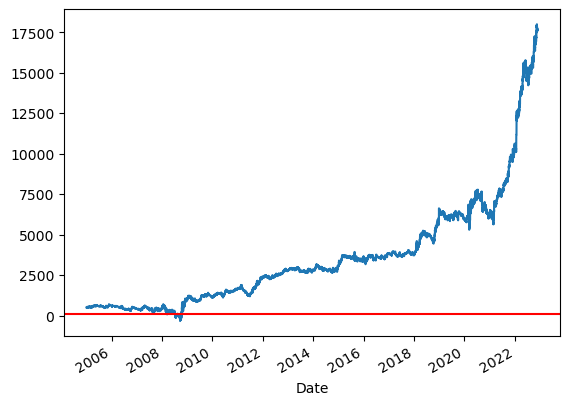

In [22]:
gain_plot_combination_return(buy_value=3,sell_value=-3)['capital'].plot()
plt.axhline(y=100,color='r',linestyle='-')

/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_13178/3753679273.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  gain_plot_combination_return(buy_value=3,sell_value=-3)['2022']['capital'].plot()


<AxesSubplot:xlabel='Date'>

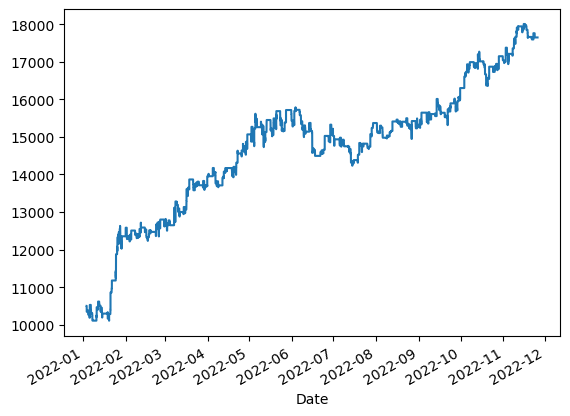

In [23]:
gain_plot_combination_return(buy_value=3,sell_value=-3)['2022']['capital'].plot()

<AxesSubplot:xlabel='Date'>

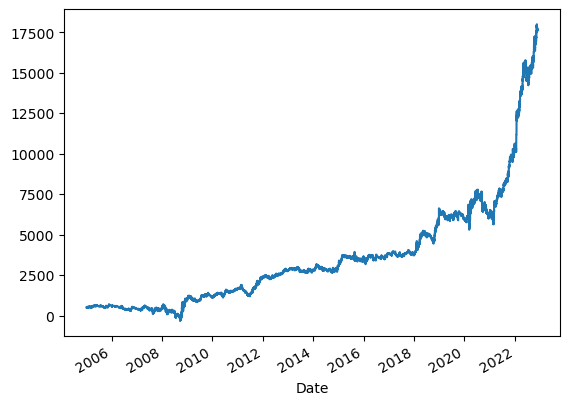

In [156]:
gain_plot_combination_return(buy_value=3,sell_value=-3)["capital"].plot()

<AxesSubplot:xlabel='Date'>

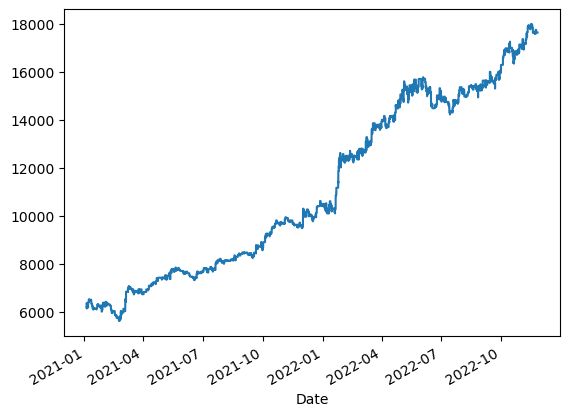

In [160]:
gain_plot_combination_return(buy_value=3,sell_value=-3)["capital"].loc["2021":"2022"].plot()

In [71]:
gain_plot_combination_return(buy_value=3,sell_value=-3).to_csv("renko_capital_gain.csv")

In [47]:
gain_plot_no_stoploss(buy_value=3,sell_value=3)

,Open,High,Low,Close,Volume,hours,Date,bar_num,atr,signal,return,cum_return,stop_loss,return_dollar,cum_return_dollar
Date,,,,,,,,,,,,,,,
2005-01-03 09:30:00,87.0610,87.1326,87.0109,87.1111,1251700,intraday,2005-01-03 09:30:00,1.0,NaN,Buy Put,0.0,0.0000,0.0,0.0,0.00
2005-01-03 09:35:00,87.1111,87.2042,87.0968,87.1827,934900,intraday,2005-01-03 09:35:00,1.0,NaN,,0.0,0.0000,0.0,0.0,0.00
2005-01-03 09:40:00,87.1541,87.1684,87.0968,87.1326,865500,intraday,2005-01-03 09:40:00,1.0,NaN,,0.0,0.0000,0.0,0.0,0.00
2005-01-03 09:45:00,87.1326,87.1684,87.0753,87.0968,584700,intraday,2005-01-03 09:45:00,1.0,NaN,,0.0,0.0000,0.0,0.0,0.00
2005-01-03 09:50:00,87.1326,87.1326,87.0180,87.0180,621600,intraday,2005-01-03 09:50:00,1.0,NaN,,0.0,0.0000,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25 15:30:00,402.3600,402.3600,402.3600,402.3600,100,intraday,2022-11-25 15:30:00,1.0,0.349082,,0.0,165.0156,0.0,0.0,8250.78
2022-11-25 15:35:00,402.4800,402.4800,402.4800,402.4800,900,intraday,2022-11-25 15:35:00,1.0,0.344666,,0.0,165.0156,0.0,0.0,8250.78
2022-11-25 15:40:00,402.4800,402.4800,402.3900,402.3900,611,intraday,2022-11-25 15:40:00,1.0,0.343332,,0.0,165.0156,0.0,0.0,8250.78


Text(0, 0.5, 'Cummulative Gain in $')

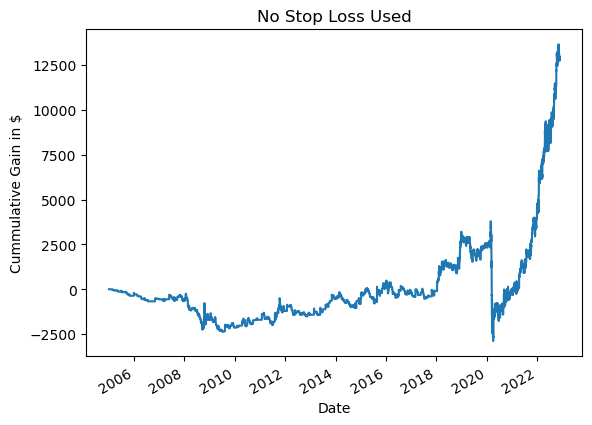

In [48]:
gain_plot_no_stoploss(buy_value=3,sell_value=-3)['cum_return_dollar'].plot()
plt.title('No Stop Loss Used')
plt.ylabel('Cummulative Gain in $')

In [72]:
gain_plot_combination_return(buy_value=3,sell_value=3)

,Open,High,Low,Close,Volume,hours,Date,bar_num,atr,signal,return,cum_return,stop_loss,return_dollar,cum_return_dollar,capital
Date,,,,,,,,,,,,,,,,
2005-01-03 09:30:00,87.0610,87.1326,87.0109,87.1111,1251700,intraday,2005-01-03 09:30:00,1.0,NaN,,0.00,0.0000,0.000000,0.0,0.000,500.000
2005-01-03 09:35:00,87.1111,87.2042,87.0968,87.1827,934900,intraday,2005-01-03 09:35:00,1.0,NaN,,0.00,0.0000,0.000000,0.0,0.000,500.000
2005-01-03 09:40:00,87.1541,87.1684,87.0968,87.1326,865500,intraday,2005-01-03 09:40:00,1.0,NaN,Buy Put,0.00,0.0000,NaN,0.0,0.000,500.000
2005-01-03 09:45:00,87.1326,87.1684,87.0753,87.0968,584700,intraday,2005-01-03 09:45:00,1.0,NaN,,0.00,0.0000,NaN,0.0,0.000,500.000
2005-01-03 09:50:00,87.1326,87.1326,87.0180,87.0180,621600,intraday,2005-01-03 09:50:00,1.0,NaN,,0.00,0.0000,NaN,0.0,0.000,500.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25 15:30:00,402.3600,402.3600,402.3600,402.3600,100,intraday,2022-11-25 15:30:00,1.0,0.349082,,0.00,357.1299,0.000000,0.0,17856.495,18356.495
2022-11-25 15:35:00,402.4800,402.4800,402.4800,402.4800,900,intraday,2022-11-25 15:35:00,1.0,0.344666,,0.00,357.1299,0.000000,0.0,17856.495,18356.495
2022-11-25 15:40:00,402.4800,402.4800,402.3900,402.3900,611,intraday,2022-11-25 15:40:00,1.0,0.343332,,0.00,357.1299,403.106902,0.0,17856.495,18356.495


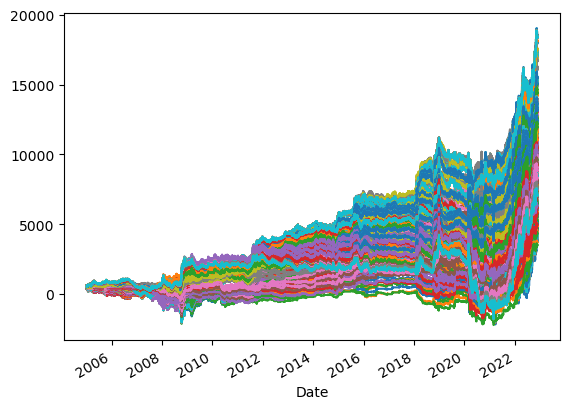

In [73]:
for i in range(-10,10):
    for j in range(-10,10):
        gain_plot_combination_return(buy_value=i,sell_value=j)['capital'].plot()

In [79]:
cum_return=[]
parameters=[]
for i in range(-10,11):
    for j in range(-10,11):
        parameters.append((i,j))
        cum_return.append(gain_plot_combination_return(buy_value=i,sell_value=j)['capital'].iloc[-1])

In [80]:
df_parameter=pd.DataFrame(columns=['parameter','cum_return'])
df_parameter

,parameter,cum_return


In [81]:
df_parameter["parameter"]=parameters
df_parameter["cum_return"]=cum_return

In [82]:
df_parameter.sort_values(by=['cum_return'],ascending=False)

,parameter,cum_return
282,"(3, -1)",18488.620
283,"(3, 0)",18488.620
287,"(3, 4)",18370.495
293,"(3, 10)",18370.495
292,"(3, 9)",18370.495
...,...,...
400,"(9, -9)",3701.630
401,"(9, -8)",3501.445
420,"(10, -10)",3259.610
421,"(10, -9)",3217.980


In [83]:
df_parameter.sort_values(by=['cum_return'],ascending=False).to_csv('parameters_renko.csv')

Text(0.5, 1.0, 'Amount increase in $ on investement with maximize parameter')

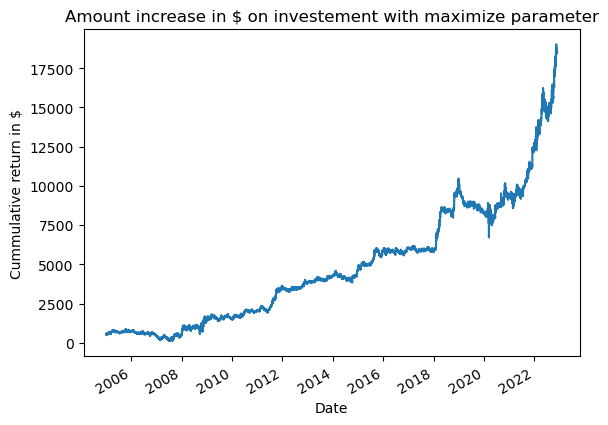

In [85]:
gain_plot_combination_return(buy_value=3,sell_value=-1)['capital'].plot()
plt.ylabel("Cummulative return in $")
plt.title("Amount increase in $ on investement with maximize parameter")

Text(0, 0.5, 'Cummulative Gain in $')

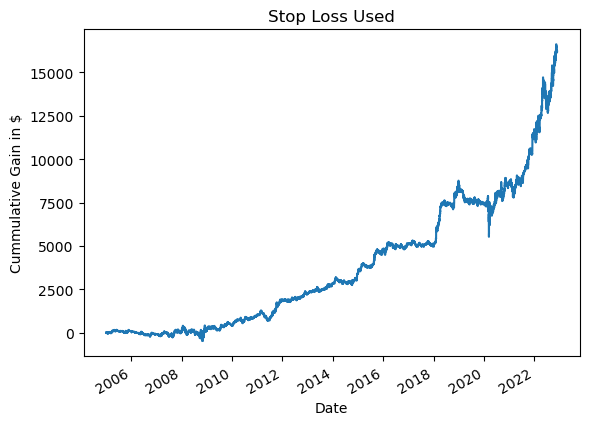

In [43]:
gain_plot_combination_return(buy_value=3,sell_value=-3)['cum_return_dollar'].plot()
plt.title('Stop Loss Used')
plt.ylabel('Cummulative Gain in $')

<AxesSubplot:xlabel='Date'>

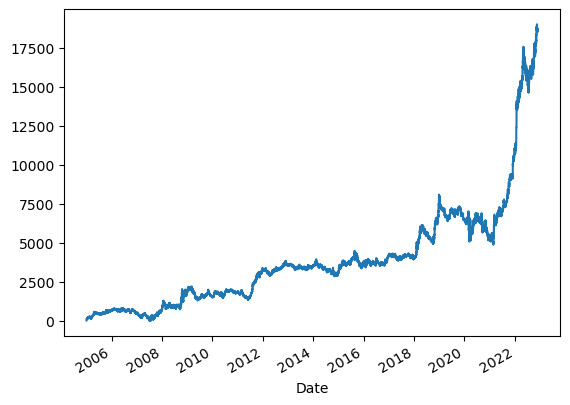

In [25]:
gain_plot_combination_return(buy_value=3,sell_value=3)['cum_return_dollar'].plot()
plt.title('')

<AxesSubplot:xlabel='Date'>

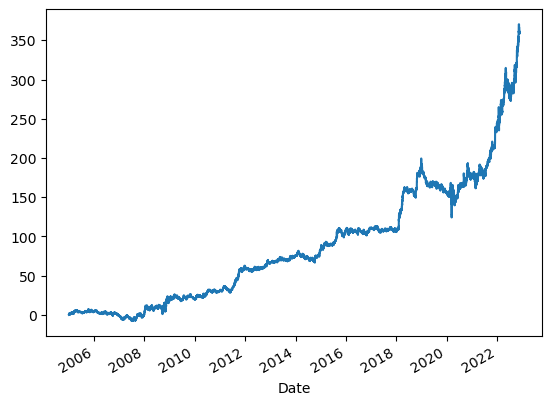

In [33]:
 gain_plot_combination_return(buy_value=3,sell_value=-1)['cum_return'].plot()

In [ ]:
spy['90']

In [26]:
gain_plot_combination_return(buy_value=3,sell_value=3).to_csv("Renko_DayTrading.csv")

In [28]:
renko_gain=gain_plot_combination_return(buy_value=3,sell_value=3)

/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_76883/1593290445.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  renko_gain['2022']["cum_return"].plot()


<AxesSubplot:xlabel='Date'>

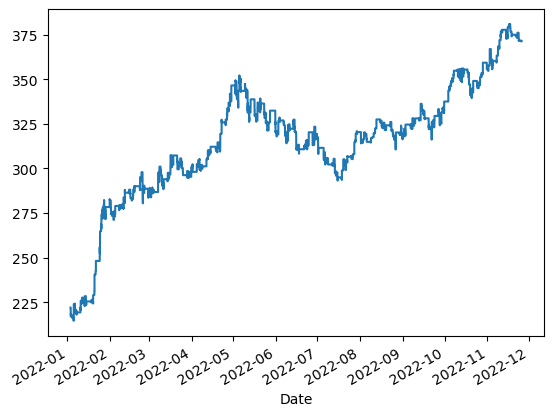

In [32]:
renko_gain['2022']["cum_return"].plot()


/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_76883/349889476.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  spy['2022']['Close'].plot()


<AxesSubplot:xlabel='Date'>

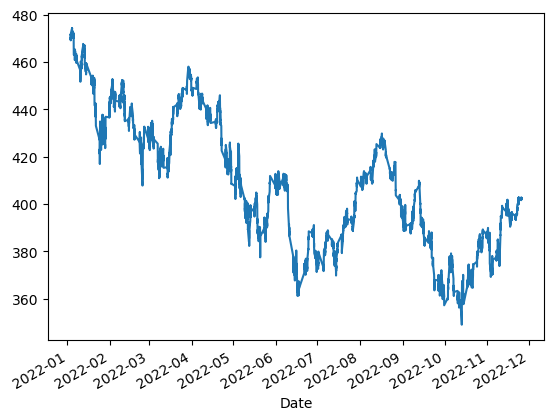

In [33]:
spy['2022']['Close'].plot()

In [92]:
# Performance Evaluation

In [98]:
CAGR(gain_plot_combination_return(buy_value=3,sell_value=-3))

0.21696952459837848

In [99]:
volatility(gain_plot_combination_return(buy_value=3,sell_value=-3))

2.204696969008448

In [100]:
sharpe(gain_plot_combination_return(buy_value=3,sell_value=-3),0.025)

0.08707297524190633

In [101]:
max_dd(gain_plot_combination_return(buy_value=3,sell_value=-3))

0.9771260931767914